<a href="https://colab.research.google.com/github/ThomasQuarck/Deep_American_Option_Pricing/blob/main/Deep_American_Option_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning for Bermudan/American Option pricing

**Author:** [Thomas Quarck]
**Date:** January 2026

## 1. Objective
The goal of this notebook is to price an **American Put Option** using a **Deep Learning** approach to solve the **Longstaff-Schwartz** algorithm.
Instead of using traditional polynomial regression (Least Squares Monte Carlo), we train a Neural Network at each time step to approximate the **Continuation Value** (conditional expectation of future payoffs).

## 2. Methodology
1.  **Simulation:** Generate 100,000 paths of the underlying asset using Geometric Brownian Motion (Vectorized Monte Carlo on GPU).
2.  **Backward Induction:** Iterate backward from maturity $T$ to $t=0$.
3.  **Deep Learning:** Train a Feed-Forward Neural Network to learn the mapping $S_t \to \mathbb{E}[V_{t+1} | S_t]$.
4.  **Optimal Decision:** At each step, compare the **Immediate Exercise Value** vs. the **Estimated Continuation Value**.

We are simulating the underlying spot $S_t$ by a Geometric Brownian Motion defined by the following SDE :

$$ dS_t = rS_tdt + σS_tdW_t$$
The discret solution used for the simulation is :
$$S_{t+1}=S_t\times \text{exp}\left((r-\frac{1}{2}\sigma^2)dt+\sigma\sqrt{dt} Z\right)$$

In [1]:
# --- 0. Imports ---
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

#checking if cuda is available
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(f"Calculations are done on {device}")


# --- 1.Hyperparameters ---
S_0 = 100     # Spot price at time 0
K = 110       # Strike price of the option
r = 0.1       # risk-free interest
sigma = 0.25  # volatility
T = 1         # Time to maturity
N = 10        # Number of exercices possible
dt = T/N      #
M = 10**5     # Number of trajectories


# --- 2. Simulation Engine ---
def BS_trajectories(S_0, r, sigma, dt, N, M):
  """
  Simulates Geometric Brownian Motion (GBM) paths using Monte Carlo.

  Args:
      S0 (float): Initial spot price.
      r (float): Risk-free interest rate.
      sigma (float): Annualized volatility.
      T (float): Time to maturity (in years).
      N (int): Number of time steps.
      M (int): Number of simulated paths (Monte Carlo samples).

  Returns:
      torch.Tensor: Matrix of asset prices of shape (M, N+1).
  """
  Z = torch.randn(M,N).to(device)

  # Calculating log returns
  drift = (r -0.5*sigma**2)*dt
  diffusion = sigma*np.sqrt(dt)*Z
  log_returns = drift + diffusion

  # reconstruct Prices
  S = torch.zeros(M,N+1).to(device)
  S[:,1:] = S_0*torch.exp(torch.cumsum(log_returns,dim=1))
  S[:,0] = S_0

  return S

Calculations are done on cuda:0


In [2]:
# --- 3. Neural Network Model ---
class DeepPricer(nn.Module):
  """
  Feed-Forward Neural Network (MLP) to approximate the Continuation Value.

  Architecture:
      Input (1) -> Linear(32) -> ReLU -> Linear(32) -> ReLU -> Output (1)
  """
  def __init__(self) -> None:
    super().__init__()

    self.net = nn.Sequential(
        nn.Linear(1,32),
        nn.ReLU(),
        nn.Linear(32,32),
        nn.ReLU(),
        nn.Linear(32,1)
    )
  def forward(self, x):
    """
    Forward pass of the network.

    Args:
        x (torch.Tensor): Current Stock Prices. Shape: (Batch_Size, 1)

    Returns:
        torch.Tensor: Estimated Continuation Values. Shape: (Batch_Size, 1)
    """
    # Normalize input by Strike (K) to help convergence (Scaling)
    return self.net(x/K)

# --- 4. Setup ---
model = DeepPricer().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

## 3. Backward Induction & Bellman Equation

The value of an American Option at time $t$, denoted $V_t$, is determined by the optimal stopping rule (Dynamic Programming):

$$V_t(S_t) = \max \left( h(S_t), \ e^{-r dt} \mathbb{E}[V_{t+1} | S_t] \right)$$

Where:
* $h(S_t) = (K - S_t)^+$ is the **Immediate Exercise Value** (Payoff).
* $\mathbb{E}[V_{t+1} | S_t]$ is the **Continuation Value** (Holding Value).

**The Neural Network's job is to approximate this conditional expectation term.**

In [3]:
# --- 5. Initialisation ---
# Generate paths
S = BS_trajectories(S_0, r, sigma, dt, N, M)

# Terminal Payoff at t=N (Maturity)
values = torch.relu(K-S[:,-1])
discount = np.exp(-r*dt)

# --- 6. Backward Induction Loop ---
print("Training Neural Network")

for i in reversed(range(1,N)):

  # A. Data Preparation
  # State (t) -> feature for the NN
  X = S[:,i].unsqueeze(1)
  # Value (t+1) -> discounted -> Target for the Neural Net
  Y = (values*discount).unsqueeze(1)

  # B. Training step (Learn the continuation value)
  model.train()
  for epoch in range(50):
    optimizer.zero_grad()
    pred = model(X)
    loss = criterion(pred,Y)
    loss.backward()
    optimizer.step()

  # C Decision step (Dynamic Programming)
  model.eval()
  with torch.no_grad():
    # Predict continuation value
    continuation = model(X).squeeze()

    # Caluculate immediate exercise value
    immediate = torch.relu(K-S[:,i])

    # Optimal Exercise Strategy:
    condition = (immediate > 0) & (immediate > continuation)

    # Update Value Vector
    values = torch.where(condition,immediate,values*discount)

  # Print progress
  if i % 2 == 0:
        print(f"Step {i}/{N} | Loss: {loss.item():.6f}")


Training Neural Network
Step 8/10 | Loss: 33.078110
Step 6/10 | Loss: 40.871025
Step 4/10 | Loss: 52.229969
Step 2/10 | Loss: 64.485382


# Visualisation

We define a confidence Interval using the following formula :

$$ \text{SE} = \frac{\text{Standart deviation of }V_0}{\sqrt{M}}$$

The 95% CI is then given by :

$$ \text{Price} \pm 1.96\times\text{SE} $$


------------------------------
Final Put Price: 11.9751
Confidence Interval (95%): [11.9188, 12.0315]
------------------------------


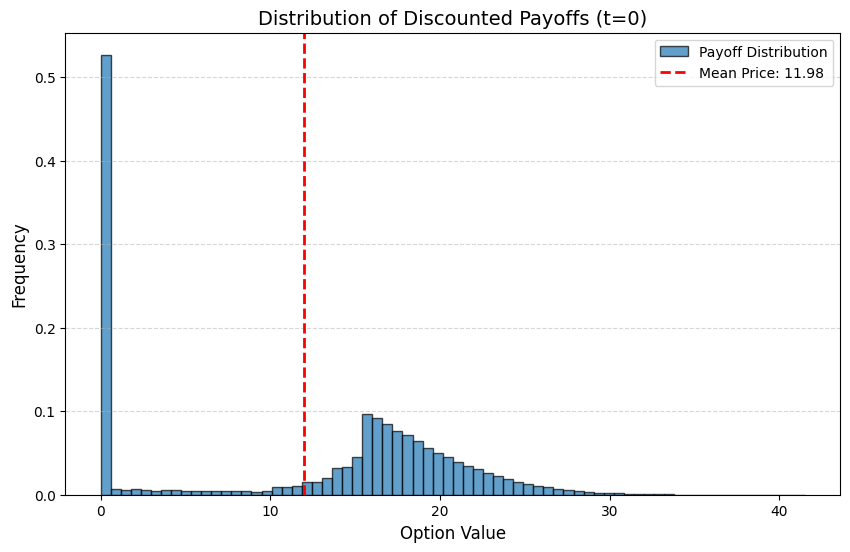

In [4]:
# --- 7. Final Pricing & Visualization ---
# Discount one last time to get Present Value at t=0
final_values = values * discount
price = final_values.mean().item()
std_error = torch.std(final_values).item() / np.sqrt(M)

print("-" * 30)
print(f"Final Put Price: {price:.4f}")
print(f"Confidence Interval (95%): [{price - 1.96*std_error:.4f}, {price + 1.96*std_error:.4f}]")
print("-" * 30)

# Visualization
plt.figure(figsize=(10, 6))

# Convert to numpy for plotting
data = final_values.cpu().numpy()

# Plot Histogram
plt.hist(data, bins=70, density=True, color='#1f77b4', edgecolor='black', alpha=0.7, label='Payoff Distribution')

# Add Mean Line
plt.axvline(price, color='red', linestyle='dashed', linewidth=2, label=f'Mean Price: {price:.2f}')

# Styling
plt.title("Distribution of Discounted Payoffs (t=0)", fontsize=14)
plt.xlabel("Option Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Grid and legend
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


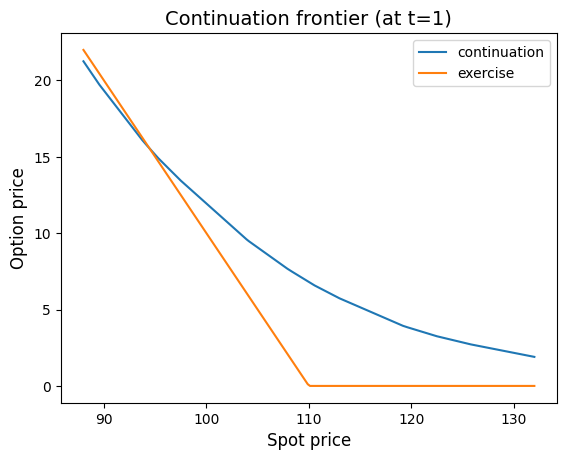

In [5]:
# --- 8. Exercice Boundary Visualisation ---
# We create a grid of sport prices (80% to 120% of the strike)
grid = torch.linspace(0.8*K, 1.2*K, 200).to(device).unsqueeze(1)

# Predict continuation
model.eval()
with torch.no_grad():
    Y = model(grid)

immediate_payoff = torch.relu(K-grid)

# Convert tensor to numpy for Matplotlib
x_axis = grid.cpu().numpy().flatten()
y_continuation = Y.cpu().numpy().flatten()
y_exercice = immediate_payoff.cpu().numpy().flatten()

# Plotting
plt.figure()
plt.plot(x_axis, y_continuation, label = 'continuation')
plt.plot(x_axis, y_exercice, label = 'exercise')

# Styling
plt.title("Continuation frontier (at t=1)", fontsize=14)
plt.xlabel("Spot price", fontsize=12)
plt.ylabel("Option price", fontsize=12)

plt.legend()
plt.show()